<a href="https://colab.research.google.com/github/redavtalab/FH-DES/blob/main/Theta_Journal1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setup Colab**

In [ ]:
pwd

'/content'

In [ ]:
cd drive/MyDrive/FH-DES/

/content/drive/MyDrive/FH-DES


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/content/gdrive/My Drive/DESlib-FH/')
!pip install xlsxwriter
!pip install openml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 119 kB 4.9 MB/s 
     |████████████████████████████████| 76 kB 4.5 MB/s 
  Created wheel for openml: filename=openml-0.12.2-py3-none-any.whl size=137326 sha256=395d0711d5e16881334d3c8184b5928a35e5ae84a25da88560ed1fd4fc559670
  Stored in directory: /root/.cache/pip/wheels/6a/20/88/cf4ac86aa18e2cd647ed16ebe274a5dacee9d0075fa02af250
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11732 sha256=5f0cf2b41f0646638d4d8f70229de19c2b6f66748b3de1889278503563514c53
  Stored in directory: /root/.cache/pip/wheels/1f/0f/15/332ca86cbebf25ddf98518caaf887945fbe1712b97a0f2493b
Successfully built openml liac-arff


## **Parameters**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from deslib.des import FHDES_Allboxes
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.calibration import CalibratedClassifierCV
import pickle
import xlsxwriter


In [ ]:
NO_classifiers = 100
no_replication = 20

theta_range = np.arange(0.03,0.301,.03)
mu_range = np.arange(0.96,.991, 0.01)

list_datasets = {"Wine","Liver","Weaning", "Seeds", "BreastCancer"} 
#"Wine","Liver","Weaning", "Seeds", "BreastCancer"
#list_datasets = {'thyroid', 'iris'} "BreastCancer","Liver", "Weaning", "Wine","Seeds"
#list_datasets = {'star', '9-pieces', 'breast-cancer', 'car', 'chess',
#                  'ionosphere', 'iris', 'mammographic'} #'drug': too less number of samples


## **Execution**

In [ ]:
"""
====================================================================
Dynamic selection with Complex classifiers: Statistical Experiment
====================================================================
"""
import multiprocessing
import pickle
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from deslib.dcs import LCA
from deslib.dcs import MLA
from deslib.dcs import OLA
from deslib.dcs import MCB
from deslib.dcs import Rank

from deslib.des import DESKNN, FHDES_JFB, DESFHMW_JFB, DESFHMW_allboxes, FHDES_prior, FHDES_Allboxes_vector, \
    FHDES_JFB_vector, DESFHMW_JFB_vector, FHDES_prior_vector, DESFHMW_prior_vector, DESFHMW_allboxes_vector
from deslib.des import KNORAE
from deslib.des import KNORAU
from deslib.des import KNOP
from deslib.des import METADES
from deslib.des import DESFHMW_prior
from deslib.des import FHDES_Allboxes,FHDES_Allboxes_GPU
from deslib.static.oracle import Oracle
from deslib.static.single_best import SingleBest
from deslib.util.datasets import make_P2
# from FMNN.fmnnclassification import FMNNClassification

import sklearn.preprocessing as preprocessing
import scipy.io as sio
import time
import os
import warnings
import math
from myfunctions import *

warnings.filterwarnings("ignore")

# Prepare the DS techniques. Changing k value to 7.

def initialize_ds(pool_classifiers, X_DSEL, y_DSEL, k=7):
    knorau = KNORAU(pool_classifiers, k=k)
    kne = KNORAE(pool_classifiers, k=k)
    desknn = DESKNN(pool_classifiers, k=k)
    ola = OLA(pool_classifiers, k=k)
    lca = LCA(pool_classifiers, k=k)
    mla = MLA(pool_classifiers, k=k)
    mcb = MCB(pool_classifiers, k=k)
    rank = Rank(pool_classifiers, k=k)
    knop = KNOP(pool_classifiers, k=k)
    meta = METADES(pool_classifiers, k=k)

    FH_1v = FHDES_JFB_vector(pool_classifiers, k=k, theta=theta, mu=NO_Hyperbox_Thereshold, mis_sample_based=True,
                     doContraction=False, thetaCheck=True, multiCore_process=True, shuffle_dataOrder=False)
    FH_2v = FHDES_JFB_vector(pool_classifiers, k=k, theta=theta, mu=NO_Hyperbox_Thereshold, mis_sample_based=True,
                     doContraction=True, thetaCheck=False, multiCore_process=True, shuffle_dataOrder=False)

    FH_3v = FHDES_Allboxes_vector(pool_classifiers, k=k, theta=theta, mu=NO_Hyperbox_Thereshold, mis_sample_based=True,
                          doContraction=False, thetaCheck=True, multiCore_process=True, shuffle_dataOrder=False)
    FH_4v = FHDES_Allboxes_vector(pool_classifiers, k=k, theta=theta, mu=NO_Hyperbox_Thereshold, mis_sample_based=True,
                          doContraction=True, thetaCheck=False, multiCore_process=True, shuffle_dataOrder=False)

    FH_5v = FHDES_JFB_vector(pool_classifiers, k=k, theta=theta, mu=NO_Hyperbox_Thereshold, mis_sample_based=True,
                     doContraction=True, thetaCheck=True, multiCore_process=True, shuffle_dataOrder=False)
    FH_6v = DESFHMW_JFB_vector(pool_classifiers, k=k, theta=theta, mu=NO_Hyperbox_Thereshold, mis_sample_based=True,
                       doContraction=True, thetaCheck=True, multiCore_process=True, shuffle_dataOrder=False)

    FH_7v = FHDES_Allboxes_vector(pool_classifiers, k=k, theta=theta, mu=NO_Hyperbox_Thereshold, mis_sample_based=True,
                          doContraction=True, thetaCheck=True, multiCore_process=True, shuffle_dataOrder=False)
    FH_8v = DESFHMW_allboxes_vector(pool_classifiers, k=k, theta=theta, mu=NO_Hyperbox_Thereshold, mis_sample_based=True,
                            doContraction=True, thetaCheck=True, multiCore_process=True, shuffle_dataOrder=False)

    FH_9v = FHDES_prior_vector(pool_classifiers, k=k, theta=theta, mu=NO_Hyperbox_Thereshold, mis_sample_based=True,
                       doContraction=True, thetaCheck=True, multiCore_process=True, shuffle_dataOrder=False)
    FH_10v = DESFHMW_prior_vector(pool_classifiers, k=k, theta=theta, mu=NO_Hyperbox_Thereshold, mis_sample_based=True,
                          doContraction=True, thetaCheck=True, multiCore_process=True, shuffle_dataOrder=False)


    oracle = Oracle(pool_classifiers)
    single_best = SingleBest(pool_classifiers, n_jobs=-1)
    majority_voting = pool_classifiers

    list_ds = [majority_voting, oracle,FH_1v, FH_2v, FH_3v, FH_4v, FH_5v, FH_6v, FH_7v, FH_8v, FH_9v, FH_10v]

    # fit the ds techniques
    for ds in list_ds:
        if ds != majority_voting:
            ds.fit(X_DSEL, y_DSEL)


    return list_ds, methods_names

def save_pool(datasetName,pools):
    path = ExperimentPath + "/Pools/" + datasetName + "_pools.p"
    poolspec = open(path, mode="wb")
    pickle.dump(pools, poolspec)
    poolspec.close()
def load_pool(datasetName):
    path = ExperimentPath + "/Pools/" + datasetName + "_pools.p"
    poolspec = open(path, mode="rb")
    return pickle.load(poolspec)

def save_model(tec_name,datasetName,ds):
    path = ExperimentPath + "/Models/" + tec_name +"_"+datasetName + "_model.p"
    poolspec = open(path, mode="wb")
    pickle.dump(ds, poolspec)
    poolspec.close()
def load_model(tec_name,datasetName):
    path = ExperimentPath + "/Models/" + tec_name +"_"+ datasetName + "_model.p"
    poolspec = open(path, mode="rb")
    return pickle.load(poolspec)

def save_results(tec_name,datasetName,accuracy,labels,yhat):
    path = ExperimentPath + "/Results/" + tec_name +"_"+datasetName + "_result.p"
    poolspec = open(path, mode="wb")
    pickle.dump(accuracy, poolspec)
    pickle.dump(labels, poolspec)
    pickle.dump(yhat, poolspec)
    poolspec.close()



def model_setup(datasetName):
    global methods_names
    pools = load_pool(datasetName)
    ds_matrix = []
    for itr in range(no_itr):
        pool_classifiers = pools[itr]
        [X_train, X_test, X_DSEL, y_train, y_test, y_DSEL] = np.load('Datasets3/' + datasetName + str(itr) + '.npy', allow_pickle=True)
        list_ds, methods_names = initialize_ds(pool_classifiers,X_DSEL,y_DSEL)
        ds_matrix.append(list_ds)

    for tec in range(NO_techniques):
        ds_tec = []
        for itr in range(no_itr):
            ds_tec.append(ds_matrix[itr][tec])
        save_model(methods_names[tec],datasetName,ds_tec)

def evaluate_model(datasetName):
    for tec in range(NO_techniques):
        results = []
        labels = []
        yhat = []
        ds_tec = load_model(methods_names[tec],datasetName)
        for itr in range(no_itr):
            [X_train, X_test, X_DSEL, y_train, y_test, y_DSEL] = np.load('Datasets3/' + datasetName + str(itr) + '.npy',  allow_pickle=True)
            labels.append(y_test)
            results.append(ds_tec[itr].score(X_test, y_test) * 100)
            if methods_names[tec] == 'Oracle':
                yhat.append(ds_tec[itr].predict(X_test,y_test))
            else:
                yhat.append(ds_tec[itr].predict(X_test))

        save_results(methods_names[tec],datasetName,results,labels,yhat)


datasets = {
    #     Data set of DGA1033 report
    "Wine"
}
datasets = sorted(datasets)

theta = 0
NO_Hyperbox_Thereshold = 0
ExperimentPath = "Experiment1"
NO_classifiers =100
no_itr = 20
generate_pools = False
do_train = True
do_evaluate = True

methods_names = ['MV', 'Oracle','FH_1v', 'FH_2v', 'FH_3v', 'FH_4v', 'FH_5v', 'FH_6v', 'FH_7v', 'FH_8v', 'FH_9v', 'FH_10v']
# 'FH_IJC', 'FH_2', 'FH_3', 'FH_4', 'FH_5', 'FH_6', 'FH_7', 'FH_8', 'FH_9', 'FH_10'
NO_techniques = len(methods_names)

start = time.time()

val_list = {0.03, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 }

for ind, datasetName in enomurate(datasets):
    # try:
    print(datasetName)
    theta = val_list[ind]
    NO_Hyperbox_Thereshold = 0
    if do_train:
        t1 = time.time()
        model_setup(datasetName)
        print("Train time",time.time()-t1)
    if do_evaluate:
        t1 = time.time()
        evaluate_model(datasetName)
        print("Test time", time.time() - t1)




# datasets = sorted(datasets)
# NO_datasets = len(datasets)
# whole_results = np.zeros([NO_datasets,NO_techniques,no_itr])
# dataset_count = 0
# done_list = []
#
#
# print(f"Time taken = {time.time() - start: .10f}")
# # write_whole_results_into_excel(whole_results, done_list.copy(), methods_names)
# path = ExperimentPath + "WholeResults.p"
# rfile = open(path, mode="wb")
# pickle.dump(whole_results,rfile)
# datasets = done_list
# pickle.dump(datasets,rfile)
# pickle.dump(methods_names,rfile)
# rfile.close()
#
#
# # pdata = np.concatenate((whole_results[:,0:3 ,:],whole_results[:,10 :14,:],whole_results[:,21:22,:]) , axis=1)
# # metName = methods_names[0:3]+ methods_names[10:14] + methods_names[21:22]
# # write_in_latex_table(pdata,done_list,metName,rows="datasets")
# write_in_latex_table(whole_results,done_list,methods_names,rows="datasets")
#
#
# duration = 4  # seconds
# freq = 440  # Hz
# os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))
# print("STD:" , np.average(np.std(whole_results,2),0))
#
# # methods_names[0:3]+ methods_names[10:14] + methods_names[21:22]

In [ ]:
def readpicklefile(mu):
    
    workbook = xlsxwriter.Workbook('ResultsTheta/ThetaAnalysis-'+np.str(mu)+'.xlsx')
    total = workbook.add_worksheet(name='Total')
    i = 0
    for dsname in list_datasets:
        pk = open('Theta'+dsname+'p','rb')

        randomstate = pickle.load(pk)
        dsname = pickle.load(pk)
        print(dsname)

        th = pickle.load(pk)
        ac = pickle.load(pk)
        st=pickle.load(pk)
        print(th)
        print(ac)
        print(st)

        total.write(1,i+2, dsname)
        total.write_column(2,i+2,ac)

        total.write(25,i+2, dsname)
        total.write_column(26,i+2,st)
        pk.close()
        i += 1
        
    total.write(1,1, "Theta")
    total.write_column(2,1,th)
    total.write(25,1, "Theta")
    total.write_column(26,1,th)
    workbook.close()


(210, 7)
(210,)
Seeds
theta= 0.03 	 accuracy= 91.6 	 std= 3.5
theta= 0.06 	 accuracy= 91.6 	 std= 3.5
theta= 0.09 	 accuracy= 91.6 	 std= 3.5
theta= 0.12 	 accuracy= 91.6 	 std= 3.5
theta= 0.15 	 accuracy= 91.6 	 std= 3.5
theta= 0.18 	 accuracy= 91.6 	 std= 3.5
theta= 0.21 	 accuracy= 91.6 	 std= 3.5
theta= 0.24 	 accuracy= 91.51 	 std= 3.6
theta= 0.27 	 accuracy= 91.42 	 std= 3.5
theta= 0.3 	 accuracy= 91.6 	 std= 3.7
(302, 17)
(302,)
Weaning
theta= 0.03 	 accuracy= 82.04 	 std= 4.4
theta= 0.06 	 accuracy= 82.04 	 std= 4.4
theta= 0.09 	 accuracy= 82.04 	 std= 4.4
theta= 0.12 	 accuracy= 82.04 	 std= 4.4
theta= 0.15 	 accuracy= 82.04 	 std= 4.4
theta= 0.18 	 accuracy= 81.97 	 std= 4.4
theta= 0.21 	 accuracy= 81.97 	 std= 4.4
theta= 0.24 	 accuracy= 81.84 	 std= 4.3
theta= 0.27 	 accuracy= 82.04 	 std= 4.4
theta= 0.3 	 accuracy= 81.84 	 std= 4.3
(286, 9)
(286,)
BreastCancer
theta= 0.03 	 accuracy= 75.97 	 std= 2.2
theta= 0.06 	 accuracy= 75.97 	 std= 2.2
theta= 0.09 	 accuracy= 75.97 	 

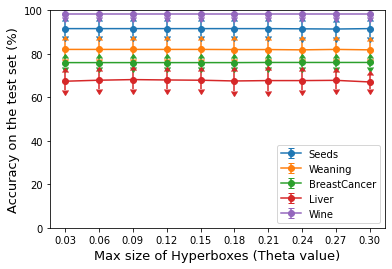

Seeds
[0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.30000000000000004]
[91.60377358490567, 91.60377358490567, 91.60377358490567, 91.60377358490567, 91.60377358490567, 91.60377358490567, 91.60377358490567, 91.50943396226417, 91.41509433962264, 91.60377358490567]
[3.5032914391749337, 3.5032914391749337, 3.5032914391749337, 3.5032914391749337, 3.5032914391749337, 3.5032914391749337, 3.5032914391749337, 3.5549893738522225, 3.4521083893456592, 3.700951933194912]
Weaning
[0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.30000000000000004]
[82.0394736842105, 82.0394736842105, 82.0394736842105, 82.0394736842105, 82.0394736842105, 81.9736842105263, 81.9736842105263, 81.84210526315789, 82.03947368421052, 81.84210526315789]
[4.408876559938551, 4.408876559938551, 4.408876559938551, 4.408876559938551, 4.408876559938551, 4.385745608552354, 4.385745608552354, 4.316110386014925, 4.447971774706674, 4.296007294030131]
BreastCancer
[0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 

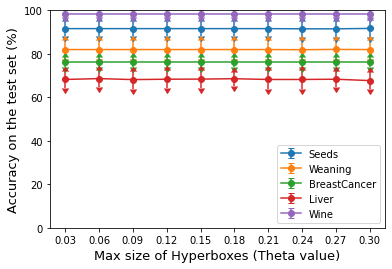

Seeds
[0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.30000000000000004]
[91.60377358490567, 91.60377358490567, 91.60377358490567, 91.60377358490567, 91.60377358490567, 91.60377358490567, 91.60377358490567, 91.50943396226415, 91.50943396226415, 91.69811320754717]
[3.553737396573089, 3.553737396573089, 3.553737396573089, 3.553737396573089, 3.553737396573089, 3.553737396573089, 3.553737396573089, 3.6047119197250588, 3.6047119197250588, 3.930691821886729]
Weaning
[0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.30000000000000004]
[81.9736842105263, 81.9736842105263, 81.9736842105263, 81.9736842105263, 81.9736842105263, 81.9736842105263, 81.9736842105263, 81.9078947368421, 82.0394736842105, 81.9736842105263]
[4.405439221785051, 4.405439221785051, 4.405439221785051, 4.405439221785051, 4.405439221785051, 4.405439221785051, 4.405439221785051, 4.361499748412424, 4.486726345165134, 4.365963163957118]
BreastCancer
[0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.30000000

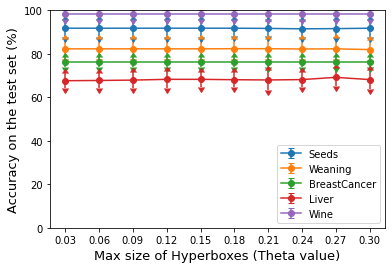

Seeds
[0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.30000000000000004]
[91.7924528301887, 91.7924528301887, 91.7924528301887, 91.7924528301887, 91.7924528301887, 91.7924528301887, 91.69811320754717, 91.50943396226415, 91.60377358490567, 91.7924528301887]
[3.8332546516811408, 3.8332546516811408, 3.8332546516811408, 3.8332546516811408, 3.8332546516811408, 3.691320291795068, 3.5997705713847017, 3.6537578737805823, 3.7487389596802894, 3.9250271816442885]
Weaning
[0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.30000000000000004]
[82.30263157894737, 82.30263157894737, 82.30263157894737, 82.30263157894737, 82.30263157894737, 82.36842105263158, 82.36842105263158, 82.23684210526315, 82.30263157894736, 81.9736842105263]
[4.697847535642683, 4.697847535642683, 4.697847535642683, 4.697847535642683, 4.697847535642683, 4.677997061745046, 4.677997061745046, 4.586427646824571, 4.878634379332213, 4.578871747711925]
BreastCancer
[0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0

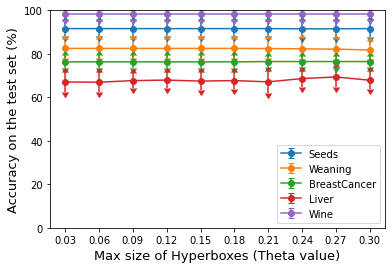

Seeds
[0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.30000000000000004]
[91.60377358490567, 91.60377358490567, 91.60377358490567, 91.60377358490567, 91.60377358490567, 91.60377358490567, 91.60377358490567, 91.50943396226415, 91.50943396226415, 91.60377358490567]
[3.6034772178838272, 3.6034772178838272, 3.6034772178838272, 3.6034772178838272, 3.6034772178838272, 3.553737396573088, 3.553737396573088, 3.604711919725057, 3.604711919725057, 3.7959244412699453]
Weaning
[0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.30000000000000004]
[82.5, 82.5, 82.5, 82.5, 82.5, 82.5, 82.4342105263158, 82.30263157894737, 82.17105263157893, 81.77631578947367]
[4.444564672119614, 4.444564672119614, 4.444564672119614, 4.444564672119614, 4.444564672119614, 4.444564672119614, 4.486726345165135, 4.770984410346288, 4.642238779557401, 4.103807940460708]
BreastCancer
[0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.30000000000000004]
[76.31944444444444, 76.31944444444444, 76.319444444444

In [ ]:

def results_theta(X,y,theta,mu):

    acc_list=[]
    for itr in range(0, no_replication):
        rng = itr
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=rng)
        X_DSEL, X_test, y_DSEL, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test,random_state=rng)
                      
        ##### **** ##### **** ###### **** ##### **** 
        scaler = preprocessing.MinMaxScaler()
        X = scaler.fit_transform(X)
        X_train = scaler.fit_transform(X_train)
        X_DSEL = scaler.transform(X_DSEL)
        X_test = scaler.transform(X_test)                                                  
        ###### **** ###### **** ##### **** ###### **** 

        model = CalibratedClassifierCV(Perceptron(max_iter=100, tol=10e-3,alpha=0.001,penalty=None),cv=5)
        pool_classifiers = BaggingClassifier(model, n_estimators=NO_classifiers, bootstrap=True, max_samples=1.0, random_state=rng)
               
        pool_classifiers.fit(X_train, y_train) 

        desfh = DESFH(pool_classifiers, k=7, theta=theta, mu=mu, mis_sample_based=True)
        desfh.fit(X_DSEL, y_DSEL)
        acc_list.append(desfh.score(X_test, y_test)*100)
        del desfh

    accuracy = np.average(acc_list)
    std = np.std(acc_list)
    return accuracy,std

def read_data(dataset):
    redata = sio.loadmat('DataSets_A/' + dataset + '.mat')
    data = redata['dataset']
    X = data[:, 0:-1]
    y = data[:, -1]
    #X = redata["X"]
    #y = redata["y"]
    #y = np.transpose(y)
    ### ### ### ### ### ### ### ### ### 
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    print(X.shape)
    print(y.shape)
    del redata
    return X,y

rand = np.random.randint(1,10000,1)
rng = np.random.RandomState(rand)    


###############################################################################
for mu in mu_range:
    fig, ax = plt.subplots()
    Theta_list=[]

    for dsname in list_datasets:
        pkfile = open('Theta'+dsname+'p','wb')
        accuracy = []
        STD = []
        Theta_list=[]
        X,y = read_data(dsname)
        #### ####  #### ####  #### ####  #### ####   
        le = preprocessing.LabelEncoder()
        y = le.fit_transform(y)

        # Theta loop
        print(dsname)
        for Theta in theta_range:
            Theta_list.append(Theta)
            acc,std = results_theta(X,y,Theta,mu)
            print("theta=" ,np.round(Theta,3), "\t accuracy=",np.round(acc,2) ,"\t std=",np.round(std,1))
            STD.append(std)
            accuracy.append(acc)

        ax.errorbar(Theta_list, accuracy, STD, fmt='-o',uplims=True, lolims=True, label=dsname)
        pickle.dump(rand,pkfile)
        pickle.dump(dsname,pkfile)
        pickle.dump(Theta_list,pkfile)
        pickle.dump(accuracy,pkfile)
        pickle.dump(STD,pkfile)
        
        pkfile.close()

    #for ds_method, name in zip(list_ds_methods, names):
    #    accuracy = []
    #    for k in k_value_list:
    #        ds_method.k = k
    #        ds_method.fit(X_train, y_train)
    #        accuracy.append(ds_method.score(X_test, y_test))


    plt.xticks(np.round(Theta_list,2))
    ax.set_ylim(0, 100)
    ax.set_xlabel('Max size of Hyperboxes (Theta value)', fontsize=13)
    ax.set_ylabel('Accuracy on the test set (%)', fontsize=13)
    ax.legend(loc='lower right')
    plt.show()
    readpicklefile(mu)
